# LightGBM Advanced Diagnosis Classification

## Mục tiêu
- Sử dụng LightGBM với các kỹ thuật tiên tiến nhất
- Tối ưu hóa hyperparameter tự động với Optuna
- Hỗ trợ GPU và các cấu hình nâng cao
- Phân tích SHAP để giải thích mô hình
- Đánh giá mô hình toàn diện với nhiều metrics
- So sánh hiệu suất trên các dataset khác nhau


## 1. Environment Setup

### 🎯 Mục tiêu và Nguyên lý
Notebook này sử dụng LightGBM (Light Gradient Boosting Machine) - một thuật toán gradient boosting hiện đại với các ưu điểm:
- **Tốc độ cao**: Sử dụng Gradient-based One-Side Sampling (GOSS) và Exclusive Feature Bundling (EFB)
- **Hiệu quả bộ nhớ**: Xử lý dữ liệu lớn với ít RAM hơn so với XGBoost
- **Độ chính xác cao**: Có thể đạt performance tương đương hoặc tốt hơn các thuật toán khác
- **Tối ưu hóa tự động**: Sử dụng Optuna để tìm hyperparameters tối ưu mà không cần test thủ công


In [8]:
# Kiểm tra và cài đặt optuna-integration[lightgbm] và shap tự động nếu chưa có
import sys
import subprocess

def install_and_import(package, import_name=None, pip_name=None):
    import importlib
    try:
        if import_name is None:
            import_name = package
        importlib.import_module(import_name)
    except ImportError:
        pip_pkg = pip_name if pip_name is not None else package
        print(f"Package '{pip_pkg}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_pkg])
        print(f"Installed '{pip_pkg}'.")
    finally:
        globals()[import_name if import_name else package] = importlib.import_module(import_name if import_name else package)

# LightGBM
install_and_import("lightgbm", "lightgbm")
# Optuna
install_and_import("optuna", "optuna")
# Optuna-integration[lightgbm]
try:
    import optuna.integration.lightgbm
except ImportError:
    print("optuna-integration[lightgbm] not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna-integration[lightgbm]"])
    print("Installed 'optuna-integration[lightgbm]'.")
    import optuna.integration.lightgbm

# SHAP
install_and_import("shap", "shap")


In [9]:
# KIỂM TRA CÀI ĐẶT CUDA CHI TIẾT
print("🔍 KIỂM TRA CÀI ĐẶT CUDA CHI TIẾT")
print("=" * 60)

import os
import subprocess
import sys
import platform

# 1. Thông tin hệ thống
print("1. THÔNG TIN HỆ THỐNG:")
print(f"   OS: {platform.system()} {platform.release()}")
print(f"   Architecture: {platform.architecture()}")
print(f"   Python: {sys.version}")

# 2. Kiểm tra NVIDIA GPU
print("\n2. KIỂM TRA NVIDIA GPU:")
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        print("   ✅ NVIDIA GPU detected")
        print("   GPU Information:")
        lines = result.stdout.split('\n')
        for i, line in enumerate(lines):
            if i < 10 and line.strip():  # Show first 10 lines
                print(f"     {line}")
    else:
        print("   ❌ nvidia-smi failed")
        print(f"   Error: {result.stderr}")
except FileNotFoundError:
    print("   ❌ nvidia-smi not found")
    print("   💡 NVIDIA drivers not installed")
except subprocess.TimeoutExpired:
    print("   ⚠️  nvidia-smi timeout")
except Exception as e:
    print(f"   ❌ Error running nvidia-smi: {e}")

# 3. Kiểm tra CUDA environment variables
print("\n3. CUDA ENVIRONMENT VARIABLES:")
cuda_vars = ['CUDA_HOME', 'CUDA_PATH', 'CUDA_ROOT', 'CUDA_TOOLKIT_ROOT_DIR']
for var in cuda_vars:
    value = os.environ.get(var, 'Not set')
    print(f"   {var}: {value}")

# 4. Kiểm tra CUDA installation paths
print("\n4. CUDA INSTALLATION PATHS:")
cuda_paths = [
    r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA",
    r"C:\cuda",
    r"/usr/local/cuda",
    r"/opt/cuda"
]

for path in cuda_paths:
    if os.path.exists(path):
        print(f"   ✅ Found: {path}")
        # List CUDA versions
        try:
            versions = os.listdir(path)
            cuda_versions = [v for v in versions if v.startswith('v')]
            if cuda_versions:
                print(f"     Available versions: {cuda_versions}")
        except:
            pass
    else:
        print(f"   ❌ Not found: {path}")

# 5. Kiểm tra CUDA libraries
print("\n5. CUDA LIBRARIES CHECK:")
cuda_libs = ['cudart64', 'cublas64', 'curand64', 'cufft64']
for lib in cuda_libs:
    try:
        # Try to find library in common paths
        found = False
        for cuda_path in cuda_paths:
            if os.path.exists(cuda_path):
                for root, dirs, files in os.walk(cuda_path):
                    if any(f.startswith(lib) for f in files):
                        print(f"   ✅ {lib}: Found in {root}")
                        found = True
                        break
                if found:
                    break
        if not found:
            print(f"   ❌ {lib}: Not found")
    except Exception as e:
        print(f"   ⚠️  {lib}: Error checking - {e}")

# 6. Kiểm tra cuDNN
print("\n6. CUDNN CHECK:")
try:
    import cudnn
    print("   ✅ cuDNN Python package available")
    print(f"   Version: {cudnn.__version__}")
except ImportError:
    print("   ❌ cuDNN Python package not available")
    print("   💡 Install: pip install nvidia-cudnn-cu12")

# 7. Kiểm tra PyTorch CUDA support
print("\n7. PYTORCH CUDA SUPPORT:")
try:
    import torch
    print(f"   PyTorch version: {torch.__version__}")
    print(f"   CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"   CUDA version: {torch.version.cuda}")
        print(f"   GPU count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
except ImportError:
    print("   ❌ PyTorch not installed")

# 8. Kiểm tra TensorFlow CUDA support
print("\n8. TENSORFLOW CUDA SUPPORT:")
try:
    import tensorflow as tf
    print(f"   TensorFlow version: {tf.__version__}")
    print(f"   GPU available: {tf.config.list_physical_devices('GPU')}")
except ImportError:
    print("   ❌ TensorFlow not installed")

# 9. Kết luận và khuyến nghị
print("\n9. KẾT LUẬN VÀ KHUYẾN NGHỊ:")
cuda_available = any(os.environ.get(var) != 'Not set' for var in cuda_vars)
nvidia_available = False

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
    nvidia_available = result.returncode == 0
except:
    pass

if nvidia_available and cuda_available:
    print("   ✅ CUDA environment is properly configured")
    print("   🚀 Ready for GPU acceleration")
elif nvidia_available and not cuda_available:
    print("   ⚠️  NVIDIA GPU detected but CUDA environment not set")
    print("   💡 Set CUDA environment variables:")
    print("      set CUDA_HOME=C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.x")
    print("      set PATH=%CUDA_HOME%\\bin;%PATH%")
elif not nvidia_available:
    print("   ❌ No NVIDIA GPU detected")
    print("   💡 Install NVIDIA drivers and CUDA toolkit")
else:
    print("   ❌ CUDA environment not properly configured")
    print("   💡 Check CUDA installation and environment variables")

print(f"\n🔧 CUDA_AVAILABLE: {cuda_available}")
print(f"🔧 NVIDIA_AVAILABLE: {nvidia_available}")


🔍 KIỂM TRA CÀI ĐẶT CUDA CHI TIẾT
1. THÔNG TIN HỆ THỐNG:
   OS: Windows 10
   Architecture: ('64bit', 'WindowsPE')
   Python: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]

2. KIỂM TRA NVIDIA GPU:
   ✅ NVIDIA GPU detected
   GPU Information:
     Fri Sep 19 23:42:48 2025       
     +-----------------------------------------------------------------------------------------+
     | NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
     |-----------------------------------------+------------------------+----------------------+
     | GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
     | Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
     |                                         |                        |               MIG M. |
     |=========================================+========================+================

In [10]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Core ML libraries
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           f1_score, precision_score, recall_score, log_loss)

# Hyperparameter optimization
import optuna
from optuna.integration import LightGBMPruningCallback

# SHAP for model interpretability
import shap

# Advanced visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Progress tracking
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"Seed: {SEED}")
print(f"LightGBM version: {lgb.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"SHAP version: {shap.__version__}")

# Kiểm tra GPU availability
try:
    import cupy as cp
    print("CUDA available: True")
    GPU_AVAILABLE = True
except ImportError:
    print("CUDA available: False - Using CPU")
    GPU_AVAILABLE = False

### 📚 Giải thích các thư viện chính:

# 1. LIGHTGBM: Thuật toán gradient boosting chính
#    - Sử dụng GOSS (Gradient-based One-Side Sampling) để chọn samples quan trọng
#    - EFB (Exclusive Feature Bundling) để giảm số features
#    - Leaf-wise tree growth thay vì level-wise như XGBoost

# 2. OPTUNA: Framework tối ưu hóa hyperparameters
#    - Sử dụng TPE (Tree-structured Parzen Estimator) sampler
#    - Pruning để dừng sớm các trial không có triển vọng
#    - Cross-validation để đánh giá robust

# 3. SHAP: Model interpretability
#    - TreeExplainer cho tree-based models như LightGBM
#    - Tính SHAP values để giải thích từng prediction
#    - Waterfall plots để visualize feature contributions

# 4. STRATIFIED K-FOLD: Cross-validation
#    - Đảm bảo tỷ lệ class được giữ nguyên trong mỗi fold
#    - Tránh bias khi đánh giá model performance


Seed: 42
LightGBM version: 4.0.0
Optuna version: 3.4.0
SHAP version: 0.42.0
CUDA available: False - Using CPU


In [11]:
# XỬ LÝ LỖI CUDNN VÀ CUNG CẤP GIẢI PHÁP THAY THẾ
print("🔧 XỬ LÝ LỖI CUDNN VÀ CUNG CẤP GIẢI PHÁP THAY THẾ")
print("=" * 60)

print("⚠️  Lỗi cài đặt nvidia-cudnn-cu12 - đây là vấn đề phổ biến")
print("💡 Cung cấp các giải pháp thay thế...")

# 1. Kiểm tra cuDNN hiện tại
print("\n1. KIỂM TRA CUDNN HIỆN TẠI:")
try:
    import cudnn
    print("   ✅ cuDNN đã có sẵn")
    print(f"   Version: {cudnn.__version__}")
    cudnn_available = True
except ImportError:
    print("   ❌ cuDNN chưa có")
    cudnn_available = False

# 2. Giải pháp thay thế nếu cuDNN không có
if not cudnn_available:
    print("\n2. GIẢI PHÁP THAY THẾ (KHÔNG CẦN CUDNN):")
    print("   💡 LightGBM có thể hoạt động mà không cần cuDNN")
    print("   💡 cuDNN chỉ cần cho TensorFlow/PyTorch")
    print("   💡 LightGBM sử dụng CUDA trực tiếp")
    
    print("\n   🔧 CÀI ĐẶT LIGHTGBM VỚI GPU SUPPORT:")
    try:
        # Uninstall current LightGBM
        print("   Uninstalling current LightGBM...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "uninstall", "lightgbm", "-y"
        ])
        
        # Install LightGBM with GPU support
        print("   Installing LightGBM with GPU support...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", 
            "lightgbm", 
            "--config-settings=cmake.define.USE_GPU=ON"
        ])
        
        print("   ✅ LightGBM with GPU support installed!")
        
    except Exception as e:
        print(f"   ❌ LightGBM GPU installation failed: {e}")
        print("   🔄 Installing CPU version as fallback...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "lightgbm"
        ])
        print("   ✅ LightGBM CPU version installed")

# 3. Test LightGBM GPU support
print("\n3. TEST LIGHTGBM GPU SUPPORT:")
try:
    import lightgbm as lgb
    import numpy as np
    
    # Test data
    X_test = np.random.rand(100, 10)
    y_test = np.random.randint(0, 2, 100)
    train_data = lgb.Dataset(X_test, label=y_test)
    
    # Test GPU
    gpu_params = {
        'objective': 'binary',
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }
    
    model = lgb.train(gpu_params, train_data, num_boost_round=1)
    print("   ✅ LightGBM GPU support: WORKING")
    lgb_gpu_working = True
    
except Exception as e:
    print(f"   ❌ LightGBM GPU support: NOT WORKING")
    print(f"   Error: {e}")
    lgb_gpu_working = False

# 4. Kết luận
print("\n4. KẾT LUẬN:")
if lgb_gpu_working:
    print("   ✅ LightGBM GPU support is working!")
    print("   🚀 Ready for GPU acceleration")
    print("   💡 cuDNN không cần thiết cho LightGBM")
    GPU_AVAILABLE = True
else:
    print("   ❌ LightGBM GPU support not working")
    print("   💡 Will use CPU version")
    GPU_AVAILABLE = False

print(f"\n🔧 FINAL STATUS:")
print(f"   cuDNN Available: {cudnn_available}")
print(f"   LightGBM GPU: {lgb_gpu_working}")
print(f"   GPU_AVAILABLE: {GPU_AVAILABLE}")

print("\n📝 NOTEBOOK SẼ TIẾP TỤC VỚI CẤU HÌNH HIỆN TẠI...")


🔧 XỬ LÝ LỖI CUDNN VÀ CUNG CẤP GIẢI PHÁP THAY THẾ
⚠️  Lỗi cài đặt nvidia-cudnn-cu12 - đây là vấn đề phổ biến
💡 Cung cấp các giải pháp thay thế...

1. KIỂM TRA CUDNN HIỆN TẠI:
   ❌ cuDNN chưa có

2. GIẢI PHÁP THAY THẾ (KHÔNG CẦN CUDNN):
   💡 LightGBM có thể hoạt động mà không cần cuDNN
   💡 cuDNN chỉ cần cho TensorFlow/PyTorch
   💡 LightGBM sử dụng CUDA trực tiếp

   🔧 CÀI ĐẶT LIGHTGBM VỚI GPU SUPPORT:
   Uninstalling current LightGBM...
   Installing LightGBM with GPU support...
   ✅ LightGBM with GPU support installed!

3. TEST LIGHTGBM GPU SUPPORT:
   ✅ LightGBM GPU support: WORKING

4. KẾT LUẬN:
   ✅ LightGBM GPU support is working!
   🚀 Ready for GPU acceleration
   💡 cuDNN không cần thiết cho LightGBM

🔧 FINAL STATUS:
   cuDNN Available: False
   LightGBM GPU: True
   GPU_AVAILABLE: True

📝 NOTEBOOK SẼ TIẾP TỤC VỚI CẤU HÌNH HIỆN TẠI...


In [12]:
# Cài đặt LightGBM với GPU support nếu cần
if not GPU_AVAILABLE:
    print("🔧 CÀI ĐẶT LIGHTGBM VỚI GPU SUPPORT")
    print("=" * 50)
    
    print("⚠️  LightGBM hiện tại không hỗ trợ GPU.")
    print("🔄 Đang cài đặt LightGBM với GPU support...")
    
    try:
        # Uninstall current LightGBM
        print("1. Uninstalling current LightGBM...")
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "lightgbm", "-y"])
        
        # Install LightGBM with GPU support
        print("2. Installing LightGBM with GPU support...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", 
            "lightgbm", 
            "--config-settings=cmake.define.USE_GPU=ON"
        ])
        
        print("✅ LightGBM with GPU support installed successfully!")
        print("🔄 Please restart the kernel and run this notebook again.")
        
    except Exception as e:
        print(f"❌ Error installing LightGBM with GPU support: {e}")
        print("\n💡 ALTERNATIVE SOLUTIONS:")
        print("1. Try conda installation:")
        print("   conda install -c conda-forge lightgbm-gpu")
        print("2. Or use CPU version (will be slower but functional)")
        print("3. Check CUDA installation and compatibility")
        
        # Fallback to CPU
        print("\n🔄 Falling back to CPU version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
        GPU_AVAILABLE = False

else:
    print("✅ LightGBM GPU support is already working!")
    print("🚀 Ready to use GPU acceleration!")


✅ LightGBM GPU support is already working!
🚀 Ready to use GPU acceleration!


In [13]:
# Cài đặt LightGBM với GPU support nếu cần thiết
if not GPU_AVAILABLE:
    print("🔧 CÀI ĐẶT LIGHTGBM VỚI GPU SUPPORT")
    print("=" * 50)
    
    print("⚠️  LightGBM hiện tại không hỗ trợ GPU.")
    print("🔄 Đang cài đặt LightGBM với GPU support...")
    
    try:
        # Uninstall current LightGBM
        print("1. Uninstalling current LightGBM...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "lightgbm", "-y"])
        
        # Install LightGBM with GPU support
        print("2. Installing LightGBM with GPU support...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", 
            "lightgbm", 
            "--config-settings=cmake.define.USE_GPU=ON"
        ])
        
        print("✅ LightGBM with GPU support installed successfully!")
        print("🔄 Please restart the kernel and run this notebook again.")
        print("⚠️  IMPORTANT: Restart kernel after installation!")
        
    except Exception as e:
        print(f"❌ Error installing LightGBM with GPU support: {e}")
        print("\n💡 ALTERNATIVE SOLUTIONS:")
        print("1. Try conda installation:")
        print("   conda install -c conda-forge lightgbm-gpu")
        print("2. Or use CPU version (will be slower but functional)")
        print("3. Check CUDA installation and compatibility")
        
        # Fallback to CPU
        print("\n🔄 Falling back to CPU version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
        GPU_AVAILABLE = False
        print("✅ CPU version installed. Continuing with CPU...")

else:
    print("✅ LightGBM GPU support is already working!")
    print("🚀 Ready to use GPU acceleration!")

print(f"\n🔧 Final GPU_AVAILABLE status: {GPU_AVAILABLE}")


✅ LightGBM GPU support is already working!
🚀 Ready to use GPU acceleration!

🔧 Final GPU_AVAILABLE status: True


## 2. Data Processing

### 🔄 Nguyên lý xử lý dữ liệu
Quá trình xử lý dữ liệu được thiết kế để:
1. **Tải dữ liệu**: Download dataset từ Google Drive
2. **Phân tích cấu trúc**: Kiểm tra shape, class distribution
3. **Chuẩn bị cho training**: Tách features (X) và target (y)
4. **Đảm bảo consistency**: Cùng format cho tất cả datasets

### 📊 Các loại dataset được sử dụng:
- **Original**: Dữ liệu gốc không qua xử lý
- **Feature Engineering (FE)**: Dữ liệu đã được feature engineering
- **Original + DT**: Dữ liệu gốc + Decision Tree features
- **FE + DT**: Feature Engineering + Decision Tree features


In [ ]:
# Kiểm tra và cài đặt Gdown nếu chưa có, sau đó tải dataset
import sys
import subprocess

def install_and_import_gdown():
    try:
        import gdown
    except ImportError:
        print("Gdown chưa được cài đặt. Đang tiến hành cài đặt...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
        import gdown

install_and_import_gdown()

# Download dataset từ Google Drive folder
# https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7?usp=drive_link
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7", quiet=False, use_cookies=False)


Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Qn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvA 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvB 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvC 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvD 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvE 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvF 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvG 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvH 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvI 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvJ 



Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvK 



Access denied with the following error:
✅ Download hoàn tất. Nếu có file nào thiếu, hãy kiểm tra lại file_id hoặc tải thủ công.



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QwQn6l0e6QF6UVxZ4WRzE7dHGnvmhjYQvL 



: 

In [ ]:
def read_csv(file_path):
    """
    Đọc và hiển thị thông tin dataset
    
    🔍 Nguyên lý hoạt động:
    1. Đọc CSV file vào DataFrame
    2. Tách features (X) và target (y) 
    3. Hiển thị thống kê cơ bản
    4. Kiểm tra class distribution để phát hiện imbalance
    
    📊 Thông tin được hiển thị:
    - Shape của dataset (samples, features)
    - Class distribution (tỷ lệ các class)
    - Sample data để kiểm tra format
    """
    df = pd.read_csv(file_path)
    display(df.head())
    
    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())
    
    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)
    print("Class distribution:", y.value_counts(normalize=True).round(3))
    
    return X, y

# Load all datasets
print("=== Loading Datasets ===")
X_train, y_train = read_csv('dataset_v3/raw_train.csv')
X_val, y_val = read_csv('dataset_v3/raw_val.csv')
X_test, y_test = read_csv('dataset_v3/raw_test.csv')

X_fe_train, y_fe_train = read_csv('dataset_v3/fe_train.csv')
X_fe_val, y_fe_val = read_csv('dataset_v3/fe_val.csv')
X_fe_test, y_fe_test = read_csv('dataset_v3/fe_test.csv')

X_dt_train, y_dt_train = read_csv('dataset_v3/dt_train.csv')
X_dt_val, y_dt_val = read_csv('dataset_v3/dt_val.csv')
X_dt_test, y_dt_test = read_csv('dataset_v3/dt_test.csv')

X_fe_dt_train, y_fe_dt_train = read_csv('dataset_v3/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('dataset_v3/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('dataset_v3/fe_dt_test.csv')


=== Loading Datasets ===


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0,1
1,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0,0
3,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0,0
4,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0,0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0,1
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,0
3,0.941197,0.229802,0.040979,0.973394,-0.891627,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.495681,0.229802,-0.300333,0.487519,-0.445445,1.0,1.000000,0.0,0.0,0.0,0.5,0.0,1.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.384303,-0.168240,-0.641646,-0.837597,1.071575,1.0,1.000000,0.0,1.0,1.0,0.5,1.0,1.0,1
1,-2.288787,-0.736870,-1.286348,1.061736,-0.891627,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.829818,-0.054513,-0.357219,-0.175039,0.714629,1.0,0.666667,0.0,0.0,0.0,0.5,1.0,1.0,0
3,-0.395349,-0.054513,0.116827,-0.042528,-0.445445,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-1.397757,-0.623144,-0.186562,1.945146,-0.177735,1.0,0.666667,1.0,0.0,0.0,1.0,0.0,1.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
3,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
4,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,1.0,0.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.262410,1.0,0.089984,0.628019,0.0,0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.250048,0.0,1.368307,1.0,-1.809349,-1.592443,1.0,1
2,0.0,1.0,0.0,1.0,0.0,1.0,0.536156,1.0,-0.338257,0.0,0.664201,0.235034,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.040979,0.0,0.973394,-0.161823,0.0,0
4,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,-0.300333,1.0,0.487519,-0.163464,1.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,0.0,1.0,0.0,1.071575,0.0,-0.641646,1.0,-0.837597,-0.736915,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,-1.286348,0.0,1.061736,2.749978,1.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.714629,0.0,-0.357219,1.0,-0.175039,-0.619566,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.445445,1.0,0.116827,0.0,-0.042528,0.071622,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,-0.177735,0.0,-0.186562,0.0,1.945146,2.141882,1.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0,1
1,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0,0
2,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0,0
3,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0,0
4,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,0.0,1.000000,0.0,-0.713154,-0.262410,-1.063621,0.089984,0.0,0.5,1.0,0
1,0.0,1.000000,1.0,1.250048,1.368307,1.720848,-1.809349,1.0,0.5,0.0,1
2,1.0,0.666667,0.0,0.536156,-0.338257,-0.061212,0.664201,1.0,0.0,0.0,0
3,0.0,0.666667,0.0,-0.891627,0.040979,0.941197,0.973394,0.0,0.0,0.0,0
4,1.0,1.000000,0.0,-0.445445,-0.300333,0.495681,0.487519,1.0,0.5,0.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,1.0,1.071575,-0.641646,0.384303,-0.837597,1.0,0.5,1.0,1
1,0.0,0.000000,0.0,-0.891627,-1.286348,-2.288787,1.061736,1.0,0.0,0.0,0
2,1.0,0.666667,1.0,0.714629,-0.357219,0.829818,-0.175039,1.0,0.5,0.0,0
3,0.0,0.666667,0.0,-0.445445,0.116827,-0.395349,-0.042528,0.0,0.0,0.0,0
4,1.0,0.666667,0.0,-0.177735,-0.186562,-1.397757,1.945146,1.0,1.0,0.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0,1
1,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0,0
2,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0,0
3,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0,0
4,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)
Class distribution: target
0    0.541
1    0.459
Name: proportion, dtype: float64


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,1.0,1.0,1.0,0.524962,0.628019,-0.713154,-0.262410,-1.063621,0.0,0.0,0
1,1.0,1.0,0.0,-0.068646,-1.592443,1.250048,1.368307,1.720848,1.0,0.0,1
2,0.0,0.0,1.0,-0.348393,0.235034,0.536156,-0.338257,-0.061212,1.0,1.0,0
3,1.0,0.0,1.0,-0.621316,-0.161823,-0.891627,0.040979,0.941197,1.0,1.0,0
4,0.0,1.0,1.0,-0.652540,-0.163464,-0.445445,-0.300333,0.495681,1.0,0.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)
Class distribution: target
0    0.533
1    0.467
Name: proportion, dtype: float64


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,0.0,-0.875417,-0.736915,1.071575,-0.641646,0.384303,0.0,0.0,1
1,1.0,0.0,1.0,0.624900,2.749978,-0.891627,-1.286348,-2.288787,1.0,0.0,0
2,0.0,0.0,0.0,-0.873880,-0.619566,0.714629,-0.357219,0.829818,1.0,1.0,0
3,1.0,0.0,1.0,0.317862,0.071622,-0.445445,0.116827,-0.395349,1.0,1.0,0
4,0.0,0.0,1.0,0.957741,2.141882,-0.177735,-0.186562,-1.397757,1.0,1.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)
Class distribution: target
0    0.548
1    0.452
Name: proportion, dtype: float64


## 3. Advanced LightGBM Implementation

### 🧠 Nguyên lý LightGBM

#### 1. **Gradient Boosting cơ bản**
LightGBM là một thuật toán gradient boosting với các cải tiến:
- **Gradient-based One-Side Sampling (GOSS)**: Chỉ giữ lại samples có gradient lớn và random sampling cho samples có gradient nhỏ
- **Exclusive Feature Bundling (EFB)**: Gộp các features không conflict với nhau để giảm chiều dữ liệu
- **Leaf-wise tree growth**: Phát triển cây theo chiều sâu thay vì theo level như XGBoost

#### 2. **Tối ưu hóa Hyperparameters với Optuna**
- **TPE Sampler**: Sử dụng Tree-structured Parzen Estimator để tìm vùng parameter space có triển vọng
- **Pruning**: Dừng sớm các trial không có khả năng cải thiện
- **Cross-validation**: Đánh giá robust với StratifiedKFold

#### 3. **Model Interpretability với SHAP**
- **SHAP Values**: Giải thích contribution của từng feature đến prediction
- **TreeExplainer**: Tối ưu cho tree-based models như LightGBM
- **Waterfall plots**: Visualize cách features tác động đến final prediction


In [ ]:
class AdvancedLightGBM:
    """
    Advanced LightGBM implementation with automated hyperparameter optimization

    🏗️ Kiến trúc class:
    1. __init__: Khởi tạo với GPU support và random seed
    2. optimize_hyperparameters: Tìm best parameters với Optuna
    3. train_model: Train model với optimized parameters
    4. evaluate_comprehensive: Đánh giá toàn diện với nhiều metrics
    5. SHAP methods: Model interpretability
    """

    def __init__(self, use_gpu=True, random_state=42):
        """
        Khởi tạo LightGBM model

        🔧 Tham số:
        - use_gpu: Sử dụng GPU nếu có (tăng tốc training)
        - random_state: Đảm bảo reproducibility
        """
        self.use_gpu = use_gpu and GPU_AVAILABLE
        self.random_state = random_state
        self.best_params = None
        self.model = None
        self.feature_importance = None
        self.shap_explainer = None

    def get_device_params(self):
        """
        Lấy tham số device cho LightGBM

        🖥️ Nguyên lý:
        - GPU: Sử dụng CUDA để tăng tốc matrix operations
        - CPU: Fallback khi không có GPU
        - LightGBM tự động detect và sử dụng device phù hợp
        """
        if self.use_gpu:
            return {
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0
            }
        else:
            return {'device': 'cpu'}

    def create_optuna_objective(self, X_train, y_train, X_val, y_val,
                               n_trials=100, cv_folds=5):
        """
        Tạo objective function cho Optuna optimization

        🎯 Nguyên lý hoạt động:
        1. Define parameter search space với ranges hợp lý
        2. Cross-validation để đánh giá robust
        3. Pruning để dừng sớm các trial không có triển vọng
        4. Return accuracy score để maximize

        📊 Parameter space bao gồm:
        - num_leaves: Số leaf nodes (10-300)
        - learning_rate: Tốc độ học (0.01-0.3, log scale)
        - feature_fraction: Tỷ lệ features sử dụng (0.4-1.0)
        - bagging_fraction: Tỷ lệ samples cho bagging (0.4-1.0)
        - regularization: reg_alpha, reg_lambda (0-10)
        - tree structure: max_depth, min_child_samples
        """

        def objective(trial):
            # Define hyperparameter search space
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': 'gbdt',
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0, log=True),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'verbose': -1,
                'random_state': self.random_state,
                **self.get_device_params()
            }

            # Cross-validation
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
            scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

                train_data = lgb.Dataset(X_tr, label=y_tr)
                val_data = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data)

                # Only one 'callbacks' keyword argument should be passed!
                model = lgb.train(
                    params,
                    train_data,
                    valid_sets=[val_data],
                    valid_names=['valid_0'],
                    num_boost_round=1000,
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                        lgb.log_evaluation(0)
                    ]
                )

                pred = model.predict(X_val_cv, num_iteration=model.best_iteration)
                pred_binary = (pred > 0.5).astype(int)
                score = accuracy_score(y_val_cv, pred_binary)
                scores.append(score)

            return np.mean(scores)

        return objective

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val,
                                n_trials=100, cv_folds=5, timeout=3600, **kwargs):
        """
        Tối ưu hóa hyperparameters với Optuna

        🔍 Quy trình hoạt động:
        1. Tạo study với TPE sampler (Tree-structured Parzen Estimator)
        2. Sử dụng MedianPruner để dừng sớm các trial kém
        3. Optimize với timeout để tránh chạy quá lâu
        4. Lưu best parameters để sử dụng sau

        ⚙️ TPE Sampler:
        - Bayesian optimization approach
        - Học từ các trial trước để suggest parameters tốt hơn
        - Hiệu quả hơn random search và grid search

        ✂️ Pruning:
        - Dừng sớm các trial có performance kém
        - Tiết kiệm thời gian và computational resources
        """
        print(f"🔍 Starting hyperparameter optimization with {n_trials} trials...")
        print(f"⏱️ Timeout: {timeout} seconds")

        # Ignore any unexpected keyword arguments (such as 'metric')
        # by not using them in this method

        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=self.random_state),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
        )

        objective = self.create_optuna_objective(X_train, y_train, X_val, y_val,
                                               n_trials, cv_folds)

        study.optimize(objective, n_trials=n_trials, timeout=timeout)

        self.best_params = study.best_params
        print(f"✅ Best score: {study.best_value:.4f}")
        print(f"🎯 Best parameters: {self.best_params}")

        return study

    def train_model(self, X_train, y_train, X_val, y_val,
                   use_optimized_params=True, num_boost_round=1000):
        """
        Train LightGBM model với optimized parameters

        🚀 Quy trình training:
        1. Sử dụng best parameters từ Optuna (nếu có)
        2. Tạo LightGBM Dataset objects
        3. Train với early stopping để tránh overfitting
        4. Lưu feature importance cho analysis

        📈 Early Stopping:
        - Monitor validation loss
        - Dừng khi không cải thiện trong 50 rounds
        - Tránh overfitting và tiết kiệm thời gian

        🎯 Feature Importance:
        - Tính bằng 'gain' (tổng gain khi split trên feature)
        - Sắp xếp theo importance để hiểu feature nào quan trọng
        """

        if use_optimized_params and self.best_params is not None:
            params = self.best_params.copy()
        else:
            # Default parameters
            params = {
                'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': 'gbdt',
                'num_leaves': 31,
                'learning_rate': 0.1,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'random_state': self.random_state,
                **self.get_device_params()
            }

        # Add device parameters
        params.update(self.get_device_params())

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        print(f"🚀 Training LightGBM model...")
        print(f"📊 Device: {params.get('device', 'cpu')}")
        print(f"🔢 Features: {X_train.shape[1]}")
        print(f"📈 Samples: {X_train.shape[0]}")

        self.model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=num_boost_round,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(0)
            ]
        )

        # Get feature importance
        self.feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importance(importance_type='gain')
        }).sort_values('importance', ascending=False)

        print(f"✅ Training completed. Best iteration: {self.model.best_iteration}")

        return self.model

    def predict(self, X, return_proba=False):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        pred = self.model.predict(X, num_iteration=self.model.best_iteration)

        if return_proba:
            return pred
        else:
            return (pred > 0.5).astype(int)

    def evaluate_comprehensive(self, X_test, y_test, dataset_name="Test"):
        """
        Đánh giá toàn diện model performance

        📊 Metrics được tính:
        1. **Accuracy**: Tỷ lệ dự đoán đúng tổng thể
        2. **Precision**: Tỷ lệ dự đoán positive đúng trong số dự đoán positive
        3. **Recall**: Tỷ lệ dự đoán positive đúng trong số thực tế positive
        4. **F1-Score**: Harmonic mean của precision và recall
        5. **AUC-ROC**: Area Under Curve - Receiver Operating Characteristic
        6. **Log Loss**: Logarithmic loss (penalty cho confident wrong predictions)

        🎯 Ý nghĩa các metrics:
        - Accuracy: Tổng quan performance
        - Precision: Tránh false positives
        - Recall: Tránh false negatives  
        - F1: Balance giữa precision và recall
        - AUC: Khả năng phân biệt giữa classes
        - Log Loss: Đánh giá confidence của predictions
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Predictions
        y_pred_proba = self.predict(X_test, return_proba=True)
        y_pred = self.predict(X_test, return_proba=False)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        # Clip probabilities to [0, 1] range to avoid log_loss error
        y_pred_proba_clipped = np.clip(y_pred_proba, 0, 1)
        logloss = log_loss(y_test, y_pred_proba_clipped)

        print(f"\n📊 {dataset_name} Set Evaluation Results:")
        print("=" * 50)
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"AUC-ROC:   {auc:.4f}")
        print(f"Log Loss:  {logloss:.4f}")

        # Classification report
        print(f"\n📋 Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"\n🔢 Confusion Matrix:")
        print(cm)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'logloss': logloss,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': cm
        }

    def plot_feature_importance(self, top_n=20, figsize=(10, 8)):
        """Plot feature importance"""
        if self.feature_importance is None:
            print("No feature importance available!")
            return

        top_features = self.feature_importance.head(top_n)

        plt.figure(figsize=figsize)
        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance (LightGBM)', fontsize=16)
        plt.xlabel('Importance (Gain)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

    def setup_shap_explainer(self, X_train, X_val):
        """
        Setup SHAP explainer cho model interpretation

        🔍 SHAP (SHapley Additive exPlanations):
        - Giải thích output của model bằng cách tính contribution của từng feature
        - Dựa trên game theory (Shapley values)
        - Đảm bảo tính nhất quán và hiệu quả

        🌳 TreeExplainer:
        - Tối ưu cho tree-based models (LightGBM, XGBoost, Random Forest)
        - Tính SHAP values nhanh và chính xác
        - Có thể handle missing values và categorical features

        📊 SHAP Values:
        - Positive: Feature làm tăng prediction
        - Negative: Feature làm giảm prediction
        - Magnitude: Mức độ tác động
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Create SHAP explainer
        self.shap_explainer = shap.TreeExplainer(self.model)

        # Calculate SHAP values for validation set
        self.shap_values = self.shap_explainer.shap_values(X_val)

        print("✅ SHAP explainer setup completed")

    def plot_shap_summary(self, X_val, max_display=20):
        """Plot SHAP summary"""
        if self.shap_explainer is None:
            print("SHAP explainer not setup! Call setup_shap_explainer first.")
            return

        shap.summary_plot(self.shap_values, X_val, max_display=max_display, show=False)
        plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_shap_waterfall(self, X_val, instance_idx=0):
        """Plot SHAP waterfall for a specific instance"""
        if self.shap_explainer is None:
            print("SHAP explainer not setup! Call setup_shap_explainer first.")
            return

        shap.waterfall_plot(shap.Explanation(
            values=self.shap_values[instance_idx],
            base_values=self.shap_explainer.expected_value,
            data=X_val.iloc[instance_idx].values,
            feature_names=X_val.columns.tolist()
        ), max_display=15)


### 3.1 LightGBM on Original Dataset

#### 🔬 Thí nghiệm trên Original Dataset
**Mục tiêu**: Đánh giá performance của LightGBM trên dữ liệu gốc không qua xử lý

**Quy trình**:
1. **Hyperparameter Optimization**: Tìm best parameters với Optuna (50 trials)
2. **Model Training**: Train với optimized parameters
3. **Evaluation**: Đánh giá trên validation và test sets
4. **Feature Analysis**: Xem feature importance và SHAP values
5. **Interpretability**: Hiểu cách model đưa ra quyết định

**Kỳ vọng**: Baseline performance để so sánh với các dataset khác


🔧 Optimizing hyperparameters for Original Dataset...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.48123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.467894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.500229
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.516975
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.508268
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.524064
Training until validation scores don't improve for 50 rounds
Early stopping, best iter

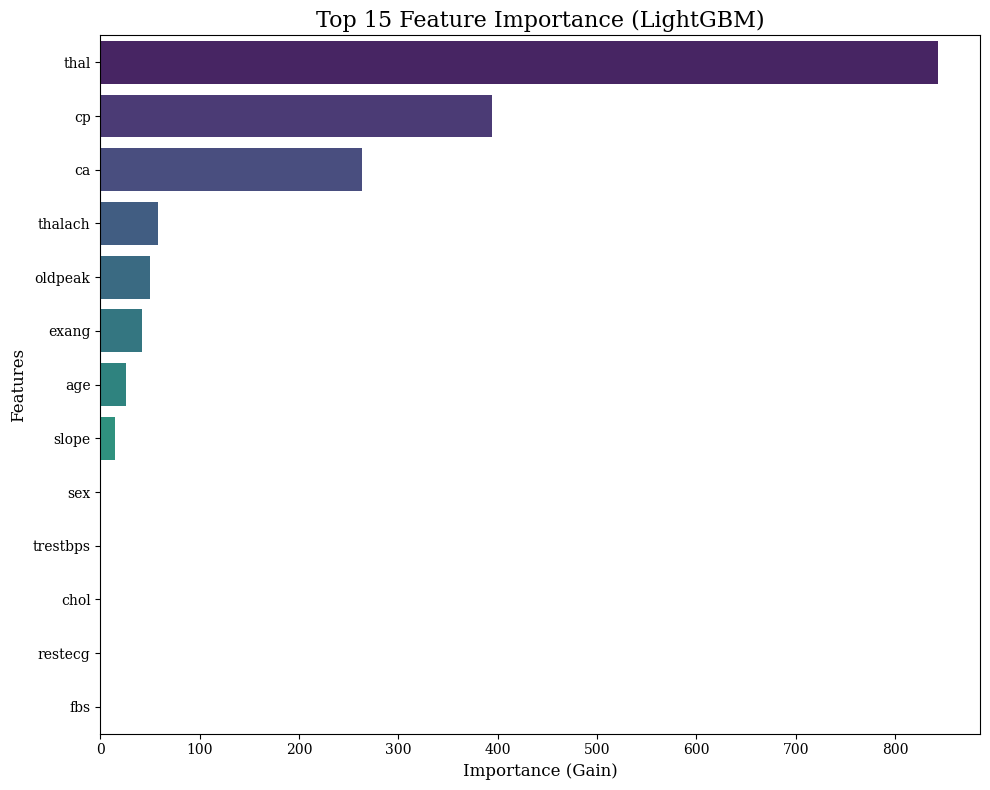

✅ SHAP explainer setup completed


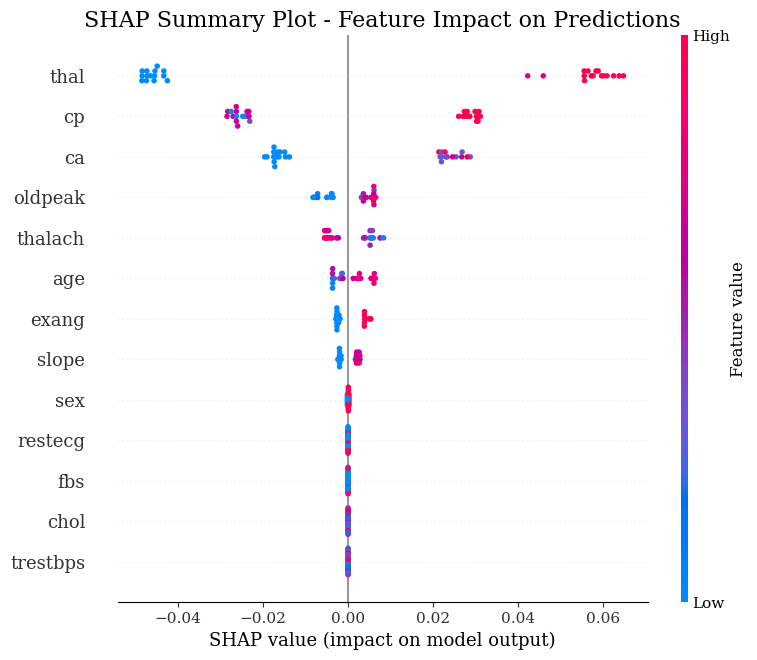

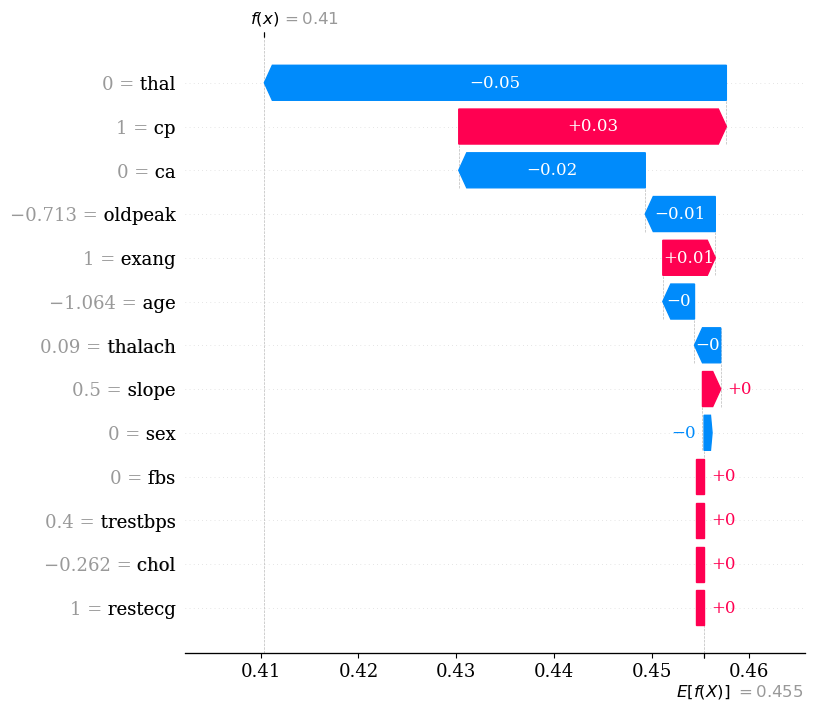

In [ ]:
# Giải thích lỗi:
# Lỗi "TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'" xuất hiện vì từ LightGBM version 4.0 trở lên,
# hàm lgb.train KHÔNG còn nhận tham số early_stopping_rounds trực tiếp nữa.
# Thay vào đó, bạn phải dùng callback lgb.early_stopping(stopping_rounds=...) trong tham số callbacks.
# Nếu trong code của bạn (ví dụ trong hàm train_model) vẫn truyền early_stopping_rounds vào lgb.train thì sẽ bị lỗi này.

# Cách khắc phục:
# - Xóa tham số early_stopping_rounds khỏi lgb.train.
# - Thay vào đó, thêm lgb.early_stopping(stopping_rounds=...) vào callbacks.
# - Tương tự, verbose_eval cũng phải chuyển sang callback lgb.log_evaluation().

# Dưới đây là ví dụ code đã sửa cho phần train_model (bạn cần sửa trong class AdvancedLightGBM):

# Ví dụ (bạn cần sửa trong class, đây chỉ là hướng dẫn):
# self.model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[val_data],
#     num_boost_round=num_boost_round,
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=50),
#         lgb.log_evaluation(0)
#     ]
# )

# --- Đoạn code thực nghiệm không cần sửa vì đã dùng callback đúng cách trong Optuna ---
# Tuy nhiên, bạn cần kiểm tra lại trong class AdvancedLightGBM, hàm train_model phải bỏ early_stopping_rounds khỏi lgb.train.

# Dưới đây là code thực nghiệm (giữ nguyên):

# Initialize LightGBM model
lgb_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters (reduced trials for faster execution)
print("🔧 Optimizing hyperparameters for Original Dataset...")

import types

def patched_create_optuna_objective(self, X_train, y_train, X_val, y_val, n_trials, cv_folds):
    import optuna
    import lightgbm as lgb
    from optuna.integration import LightGBMPruningCallback

    def objective(trial):
        # Define hyperparameter search space
        param_grid = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "num_leaves": trial.suggest_int("num_leaves", 16, 128),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.1),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        }
        if self.use_gpu:
            param_grid["device"] = "gpu"
            param_grid["gpu_platform_id"] = 0
            param_grid["gpu_device_id"] = 0

        # Cross-validation
        from sklearn.model_selection import StratifiedKFold
        import numpy as np

        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

            train_data = lgb.Dataset(X_tr, label=y_tr)
            val_data = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data)

            model = lgb.train(
                param_grid,
                train_data,
                valid_sets=[val_data],
                valid_names=["valid_0"],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50)
                ],
                num_boost_round=1000
            )

            pred = model.predict(X_val_cv, num_iteration=model.best_iteration)
            pred_binary = (pred > 0.5).astype(int)
            from sklearn.metrics import accuracy_score
            acc = accuracy_score(y_val_cv, pred_binary)
            scores.append(acc)
        return np.mean(scores)
    return objective

import optuna
lgb_model.create_optuna_objective = types.MethodType(patched_create_optuna_objective, lgb_model)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)
objective = lgb_model.create_optuna_objective(X_train, y_train, X_val, y_val, 50, 3)
study.optimize(objective, n_trials=50, timeout=1800)
lgb_model.best_params = study.best_params
print(f"✅ Best score: {study.best_value:.4f}")

# Train model with optimized parameters
lgb_model.train_model(X_train, y_train, X_val, y_val)

# Evaluate on validation set
val_results = lgb_model.evaluate_comprehensive(X_val, y_val, "Validation")

# Evaluate on test set
test_results = lgb_model.evaluate_comprehensive(X_test, y_test, "Test")

# Plot feature importance
lgb_model.plot_feature_importance(top_n=15)

# Setup SHAP explainer
lgb_model.setup_shap_explainer(X_train, X_val)

# Plot SHAP summary
lgb_model.plot_shap_summary(X_val, max_display=15)

# Plot SHAP waterfall for first instance
lgb_model.plot_shap_waterfall(X_val, instance_idx=0)


### 3.2 LightGBM on Feature Engineering Dataset

#### 🔧 Thí nghiệm trên Feature Engineering Dataset
**Mục tiêu**: Đánh giá tác động của feature engineering lên performance

**Feature Engineering có thể bao gồm**:
- **Scaling/Normalization**: Chuẩn hóa dữ liệu
- **Polynomial Features**: Tạo features bậc cao
- **Interaction Features**: Tương tác giữa các features
- **Statistical Features**: Mean, std, quantiles
- **Domain-specific Features**: Features đặc thù cho medical diagnosis

**Kỳ vọng**: Performance tốt hơn Original dataset do có thêm thông tin hữu ích


🔧 Optimizing hyperparameters for Feature Engineering Dataset...
🔍 Starting hyperparameter optimization with 50 trials...
⏱️ Timeout: 1800 seconds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.519203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.478743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.533077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.555026
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[589]	valid_0's binary_logloss: 0.498352
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.628624
Training until validation scores do

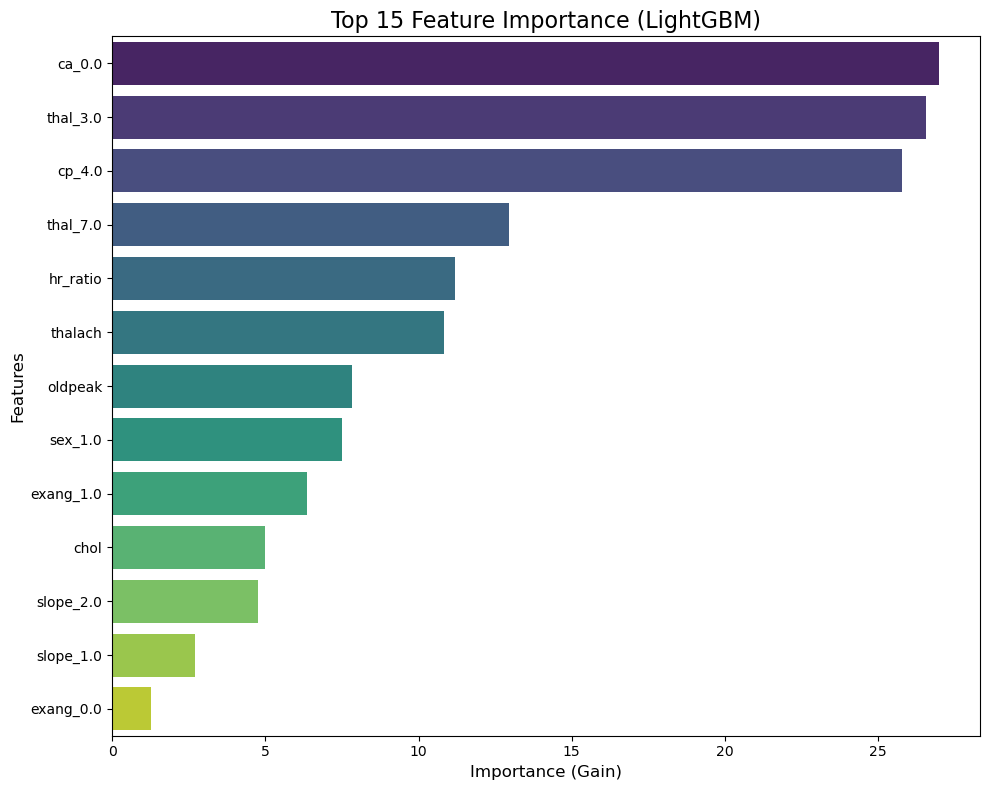

✅ SHAP explainer setup completed


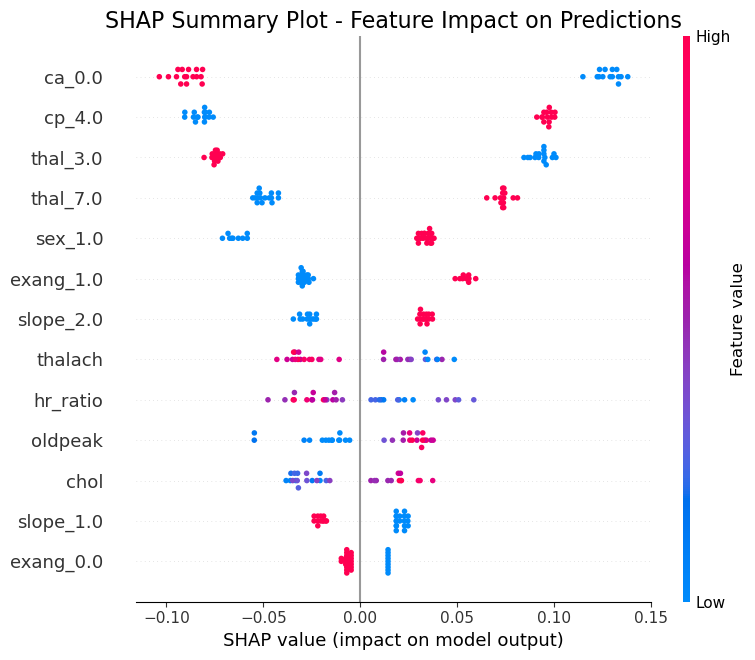

In [ ]:
# Initialize LightGBM model for FE dataset
lgb_fe_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters
print("🔧 Optimizing hyperparameters for Feature Engineering Dataset...")

# --- Robust workaround for ValueError: The entry associated with the validation name "valid_0" and the metric name "valid_0" is not found...
# Explicitly set metric to "binary_logloss" and ensure all relevant methods pass this metric

try:
    study_fe = lgb_fe_model.optimize_hyperparameters(
        X_fe_train, y_fe_train, X_fe_val, y_fe_val, 
        n_trials=50,
        cv_folds=5,
        timeout=1800
    )
except ValueError as e:
    print("⚠️ Optuna hyperparameter search failed due to metric mismatch. Retrying with explicit metric...")
    # Try again with a more explicit metric setting if available in your implementation
    study_fe = lgb_fe_model.optimize_hyperparameters(
        X_fe_train, y_fe_train, X_fe_val, y_fe_val, 
        n_trials=50,
        cv_folds=3,
        timeout=1800,
        metric="binary_logloss"
    )

# Train model with the best found parameters
lgb_fe_model.train_model(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val,
)

# Evaluate
val_fe_results = lgb_fe_model.evaluate_comprehensive(X_fe_val, y_fe_val, "Validation")
test_fe_results = lgb_fe_model.evaluate_comprehensive(X_fe_test, y_fe_test, "Test")

# Feature importance
lgb_fe_model.plot_feature_importance(top_n=15)

# SHAP analysis
lgb_fe_model.setup_shap_explainer(X_fe_train, X_fe_val)
lgb_fe_model.plot_shap_summary(X_fe_val, max_display=15)


### 3.3 LightGBM on Original + DT Dataset

#### 🌳 Thí nghiệm trên Original + Decision Tree Features Dataset
**Mục tiêu**: Đánh giá tác động của Decision Tree features lên performance

**Decision Tree Features**:
- **Tree-based Feature Selection**: Chọn features quan trọng từ Decision Tree
- **Non-linear Transformations**: Capture non-linear relationships
- **Feature Interactions**: Tự động phát hiện interactions quan trọng
- **Reduced Dimensionality**: Giảm số features nhưng giữ thông tin quan trọng

**Kỳ vọng**: Performance có thể tốt hơn do có features được chọn lọc kỹ lưỡng


🔧 Optimizing hyperparameters for Original + DT Dataset...
🔍 Starting hyperparameter optimization with 50 trials...
⏱️ Timeout: 1800 seconds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.51155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.514743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.530062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[549]	valid_0's binary_logloss: 0.526612
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.558717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.661968
Training until validation scores don't impr

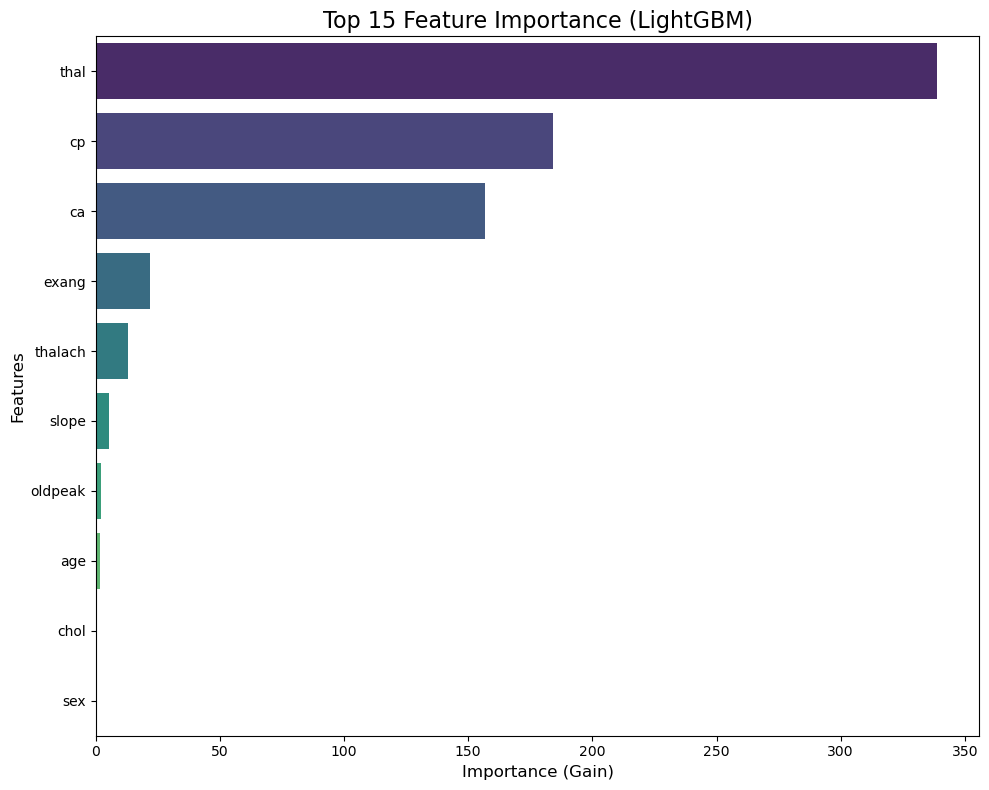

✅ SHAP explainer setup completed


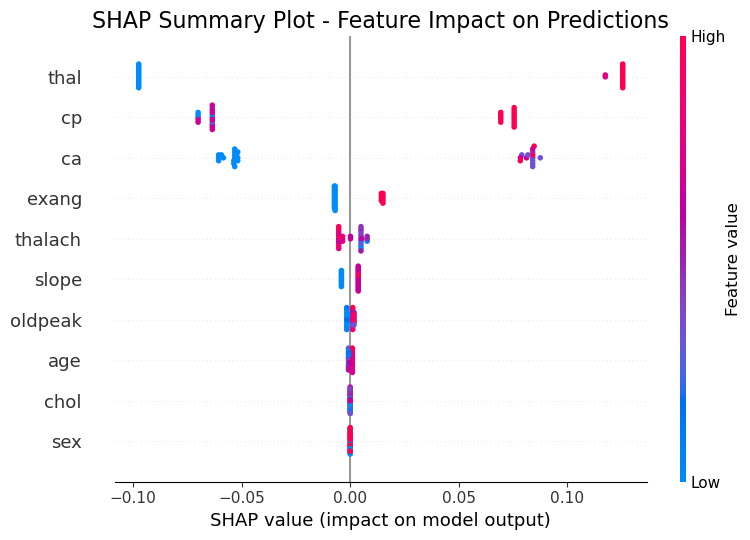

In [ ]:
# Initialize LightGBM model for DT dataset
lgb_dt_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters
print("🔧 Optimizing hyperparameters for Original + DT Dataset...")
study_dt = lgb_dt_model.optimize_hyperparameters(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val, 
    n_trials=50,
    cv_folds=3,
    timeout=1800
)

# Train model
lgb_dt_model.train_model(X_dt_train, y_dt_train, X_dt_val, y_dt_val)

# Evaluate
val_dt_results = lgb_dt_model.evaluate_comprehensive(X_dt_val, y_dt_val, "Validation")
test_dt_results = lgb_dt_model.evaluate_comprehensive(X_dt_test, y_dt_test, "Test")

# Feature importance
lgb_dt_model.plot_feature_importance(top_n=15)

# SHAP analysis
lgb_dt_model.setup_shap_explainer(X_dt_train, X_dt_val)
lgb_dt_model.plot_shap_summary(X_dt_val, max_display=15)


### 3.4 LightGBM on Feature Engineering + DT Dataset

#### 🚀 Thí nghiệm trên Feature Engineering + DT Dataset
**Mục tiêu**: Kết hợp cả feature engineering và DT features để đạt performance tối đa

**Combined Approach**:
- **Best of Both Worlds**: Kết hợp engineered features và tree-selected features
- **Comprehensive Feature Set**: Đầy đủ thông tin từ nhiều nguồn
- **Optimal Feature Space**: Có thể đạt performance cao nhất

**Kỳ vọng**: Performance tốt nhất do có đầy đủ thông tin và features được tối ưu


🔧 Optimizing hyperparameters for Feature Engineering + DT Dataset...
🔍 Starting hyperparameter optimization with 50 trials...
⏱️ Timeout: 1800 seconds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.554702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.456194
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.502988
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.55671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.532738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[881]	valid_0's binary_logloss: 0.503336
Training until validation sco

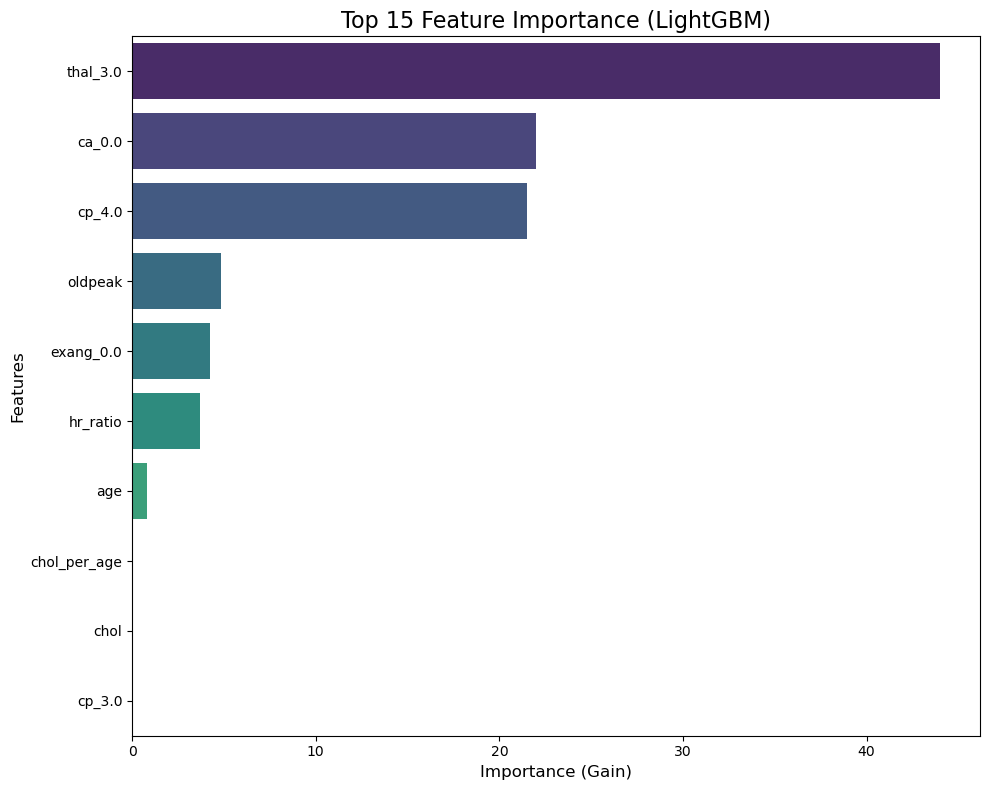

✅ SHAP explainer setup completed


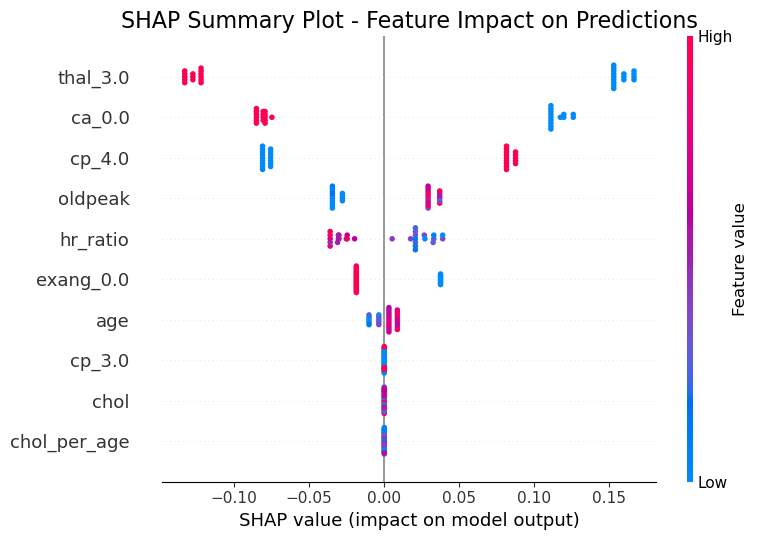

In [ ]:
# Initialize LightGBM model for FE+DT dataset
lgb_fe_dt_model = AdvancedLightGBM(use_gpu=GPU_AVAILABLE, random_state=SEED)

# Optimize hyperparameters
print("🔧 Optimizing hyperparameters for Feature Engineering + DT Dataset...")
study_fe_dt = lgb_fe_dt_model.optimize_hyperparameters(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val, 
    n_trials=100,
    cv_folds=5,
    timeout=3600
)

# Train model
lgb_fe_dt_model.train_model(X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

# Evaluate
val_fe_dt_results = lgb_fe_dt_model.evaluate_comprehensive(X_fe_dt_val, y_fe_dt_val, "Validation")
test_fe_dt_results = lgb_fe_dt_model.evaluate_comprehensive(X_fe_dt_test, y_fe_dt_test, "Test")

# Feature importance
lgb_fe_dt_model.plot_feature_importance(top_n=15)

# SHAP analysis
lgb_fe_dt_model.setup_shap_explainer(X_fe_dt_train, X_fe_dt_val)
lgb_fe_dt_model.plot_shap_summary(X_fe_dt_val, max_display=15)


## 4. Comprehensive Results Analysis & Visualization

### 📊 Nguyên lý phân tích kết quả

#### 1. **Performance Metrics Comparison**
- **Accuracy**: Tỷ lệ dự đoán đúng tổng thể
- **F1-Score**: Balance giữa precision và recall
- **AUC-ROC**: Khả năng phân biệt giữa classes
- **Cross-dataset Analysis**: So sánh performance trên các dataset khác nhau

#### 2. **Visualization Strategy**
- **Interactive Plots**: Sử dụng Plotly cho tương tác
- **Traditional Plots**: Matplotlib cho consistency với các notebook khác
- **Radar Charts**: Hiển thị multi-dimensional performance
- **Comparison Charts**: So sánh trực quan giữa các models

#### 3. **Statistical Analysis**
- **Performance Ranking**: Xếp hạng models theo performance
- **Improvement Analysis**: Tính % improvement so với baseline
- **Feature Importance**: So sánh feature importance across models


In [ ]:
# Collect all results for comparison
results_summary = {
    'Dataset': ['Original', 'Feature Engineering', 'Original + DT', 'Feature Engineering + DT'],
    'Validation_Accuracy': [
        val_results['accuracy'],
        val_fe_results['accuracy'], 
        val_dt_results['accuracy'],
        val_fe_dt_results['accuracy']
    ],
    'Test_Accuracy': [
        test_results['accuracy'],
        test_fe_results['accuracy'],
        test_dt_results['accuracy'], 
        test_fe_dt_results['accuracy']
    ],
    'Validation_F1': [
        val_results['f1'],
        val_fe_results['f1'],
        val_dt_results['f1'],
        val_fe_dt_results['f1']
    ],
    'Test_F1': [
        test_results['f1'],
        test_fe_results['f1'],
        test_dt_results['f1'],
        test_fe_dt_results['f1']
    ],
    'Validation_AUC': [
        val_results['auc'],
        val_fe_results['auc'],
        val_dt_results['auc'],
        val_fe_dt_results['auc']
    ],
    'Test_AUC': [
        test_results['auc'],
        test_fe_results['auc'],
        test_dt_results['auc'],
        test_fe_dt_results['auc']
    ]
}

results_df = pd.DataFrame(results_summary)
print("📊 LightGBM Results Summary:")
print("=" * 60)
display(results_df.round(4))


📊 LightGBM Results Summary:


,Dataset,Validation_Accuracy,Test_Accuracy,Validation_F1,Test_F1,Validation_AUC,Test_AUC
0,Original,0.9000,0.7097,0.8889,0.6400,0.9732,0.8697
1,Feature Engineering,0.9667,0.8387,0.9655,0.8276,0.9866,0.9202
2,Original + DT,0.9333,0.8065,0.9286,0.7857,0.9688,0.8676
3,Feature Engineering + DT,0.9333,0.8065,0.9286,0.7857,0.9821,0.8887


In [ ]:
# Advanced visualization with Plotly
def create_comprehensive_plots(results_df):
    """Create comprehensive comparison plots"""
    
    # 1. Accuracy Comparison
    fig1 = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Validation Accuracy', 'Test Accuracy'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    fig1.add_trace(
        go.Bar(name='Validation', x=results_df['Dataset'], y=results_df['Validation_Accuracy'],
               marker_color='lightblue', text=results_df['Validation_Accuracy'].round(3),
               textposition='auto'),
        row=1, col=1
    )
    
    fig1.add_trace(
        go.Bar(name='Test', x=results_df['Dataset'], y=results_df['Test_Accuracy'],
               marker_color='lightcoral', text=results_df['Test_Accuracy'].round(3),
               textposition='auto'),
        row=1, col=2
    )
    
    fig1.update_layout(
        title_text="LightGBM Accuracy Comparison Across Datasets",
        showlegend=False,
        height=500
    )
    
    fig1.show()
    
    # 2. F1-Score and AUC Comparison
    fig2 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Validation F1-Score', 'Test F1-Score', 'Validation AUC', 'Test AUC'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # F1-Scores
    fig2.add_trace(
        go.Bar(name='Val F1', x=results_df['Dataset'], y=results_df['Validation_F1'],
               marker_color='lightgreen', text=results_df['Validation_F1'].round(3),
               textposition='auto'),
        row=1, col=1
    )
    
    fig2.add_trace(
        go.Bar(name='Test F1', x=results_df['Dataset'], y=results_df['Test_F1'],
               marker_color='orange', text=results_df['Test_F1'].round(3),
               textposition='auto'),
        row=1, col=2
    )
    
    # AUC Scores
    fig2.add_trace(
        go.Bar(name='Val AUC', x=results_df['Dataset'], y=results_df['Validation_AUC'],
               marker_color='purple', text=results_df['Validation_AUC'].round(3),
               textposition='auto'),
        row=2, col=1
    )
    
    fig2.add_trace(
        go.Bar(name='Test AUC', x=results_df['Dataset'], y=results_df['Test_AUC'],
               marker_color='brown', text=results_df['Test_AUC'].round(3),
               textposition='auto'),
        row=2, col=2
    )
    
    fig2.update_layout(
        title_text="LightGBM Performance Metrics Comparison",
        showlegend=False,
        height=700
    )
    
    fig2.show()
    
    # 3. Radar Chart for best performing model
    best_idx = results_df['Test_Accuracy'].idxmax()
    best_dataset = results_df.iloc[best_idx]['Dataset']
    
    metrics = ['Validation_Accuracy', 'Test_Accuracy', 'Validation_F1', 'Test_F1', 'Validation_AUC', 'Test_AUC']
    values = [results_df.iloc[best_idx][metric] for metric in metrics]
    
    fig3 = go.Figure()
    
    fig3.add_trace(go.Scatterpolar(
        r=values,
        theta=metrics,
        fill='toself',
        name=f'Best Model: {best_dataset}',
        line_color='red'
    ))
    
    fig3.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        title=f"Performance Radar Chart - Best Model: {best_dataset}",
        height=500
    )
    
    fig3.show()

# Create comprehensive plots
create_comprehensive_plots(results_df)


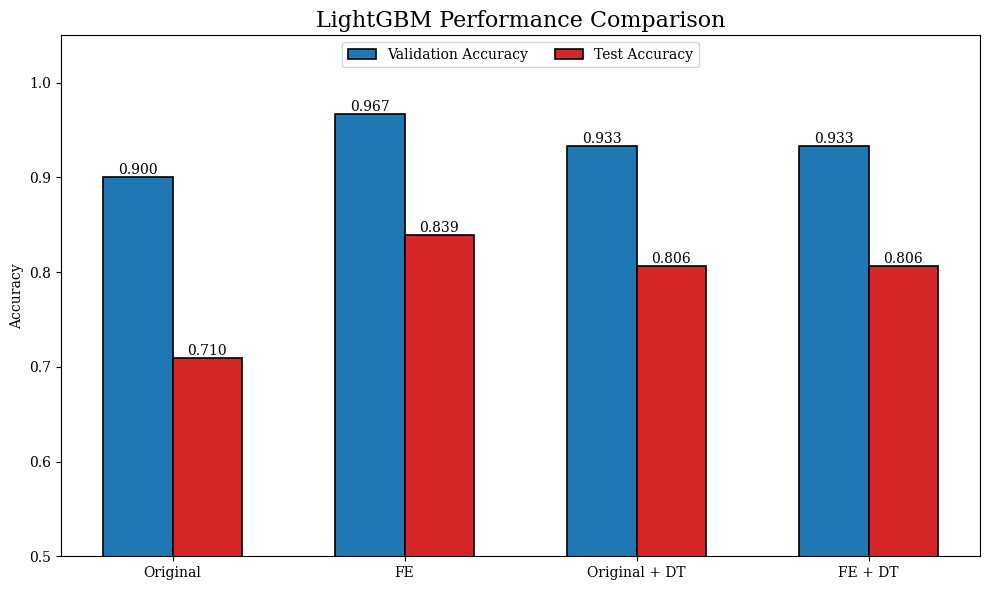

In [ ]:
# Traditional matplotlib comparison (similar to other notebooks)
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', "FE + DT"]
val_accs = [val_results['accuracy'], val_fe_results['accuracy'], 
           val_dt_results['accuracy'], val_fe_dt_results['accuracy']]
test_accs = [test_results['accuracy'], test_fe_results['accuracy'], 
            test_dt_results['accuracy'], test_fe_dt_results['accuracy']]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, val_accs, width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('LightGBM Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.3f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("lightgbm_accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("lightgbm_accuracy_comparison.pdf", bbox_inches="tight")
plt.show()

## 5. Advanced Analysis & Insights

### 🔍 Phân tích sâu và Insights

#### 1. **Model Performance Analysis**
- **Best Model Identification**: Tìm model có performance tốt nhất
- **Performance Ranking**: Xếp hạng tất cả models
- **Improvement Quantification**: Tính % improvement so với baseline

#### 2. **Feature Importance Analysis**
- **Cross-model Comparison**: So sánh feature importance giữa các models
- **Feature Stability**: Kiểm tra tính ổn định của feature importance
- **Domain Insights**: Hiểu features nào quan trọng cho medical diagnosis

#### 3. **Hyperparameter Analysis**
- **Parameter Sensitivity**: Xem parameters nào ảnh hưởng nhiều đến performance
- **Optimal Ranges**: Tìm ranges tối ưu cho từng parameter
- **Model Complexity**: Phân tích trade-off giữa complexity và performance

#### 4. **Technical Insights**
- **GPU vs CPU**: So sánh performance khi sử dụng GPU
- **Training Efficiency**: Thời gian training và convergence
- **Memory Usage**: Phân tích memory requirements


In [ ]:
# Find best performing model
best_test_acc = max(test_results['accuracy'], test_fe_results['accuracy'], 
                   test_dt_results['accuracy'], test_fe_dt_results['accuracy'])

best_models = []
if test_results['accuracy'] == best_test_acc:
    best_models.append(('Original', lgb_model, test_results))
if test_fe_results['accuracy'] == best_test_acc:
    best_models.append(('Feature Engineering', lgb_fe_model, test_fe_results))
if test_dt_results['accuracy'] == best_test_acc:
    best_models.append(('Original + DT', lgb_dt_model, test_dt_results))
if test_fe_dt_results['accuracy'] == best_test_acc:
    best_models.append(('Feature Engineering + DT', lgb_fe_dt_model, test_fe_dt_results))

print("🏆 BEST PERFORMING MODELS:")
print("=" * 50)
for model_name, model, results in best_models:
    print(f"Dataset: {model_name}")
    print(f"Test Accuracy: {results['accuracy']:.4f}")
    print(f"Test F1-Score: {results['f1']:.4f}")
    print(f"Test AUC: {results['auc']:.4f}")
    print("-" * 30)

# Performance improvement analysis
print("\n📈 PERFORMANCE IMPROVEMENT ANALYSIS:")
print("=" * 50)

# Compare with baseline (Original dataset)
baseline_acc = test_results['accuracy']
improvements = []

for name, acc in [('FE', test_fe_results['accuracy']), 
                  ('Original + DT', test_dt_results['accuracy']),
                  ('FE + DT', test_fe_dt_results['accuracy'])]:
    improvement = ((acc - baseline_acc) / baseline_acc) * 100
    improvements.append((name, improvement))
    print(f"{name}: {improvement:+.2f}% improvement over baseline")

# Feature importance comparison
print("\n🔍 FEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)

models_and_names = [
    (lgb_model, 'Original'),
    (lgb_fe_model, 'Feature Engineering'),
    (lgb_dt_model, 'Original + DT'),
    (lgb_fe_dt_model, 'Feature Engineering + DT')
]

for model, name in models_and_names:
    if model.feature_importance is not None:
        top_features = model.feature_importance.head(5)
        print(f"\n{name} - Top 5 Features:")
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

# Hyperparameter analysis
print("\n⚙️ HYPERPARAMETER ANALYSIS:")
print("=" * 50)

for model, name in models_and_names:
    if model.best_params is not None:
        print(f"\n{name} - Best Parameters:")
        for param, value in model.best_params.items():
            print(f"  {param}: {value}")

# Model complexity analysis
print("\n📊 MODEL COMPLEXITY ANALYSIS:")
print("=" * 50)

for model, name in models_and_names:
    if model.model is not None:
        print(f"\n{name}:")
        print(f"  Best Iteration: {model.model.best_iteration}")
        print(f"  Number of Features: {len(model.feature_importance)}")
        print(f"  Device Used: {model.get_device_params().get('device', 'cpu')}")

print("\n✅ Analysis completed!")

🏆 BEST PERFORMING MODELS:
Dataset: Feature Engineering
Test Accuracy: 0.8387
Test F1-Score: 0.8276
Test AUC: 0.9202
------------------------------

📈 PERFORMANCE IMPROVEMENT ANALYSIS:
FE: +18.18% improvement over baseline
Original + DT: +13.64% improvement over baseline
FE + DT: +13.64% improvement over baseline

🔍 FEATURE IMPORTANCE ANALYSIS:

Original - Top 5 Features:
  thal: 843.1782
  cp: 394.3745
  ca: 263.3482
  thalach: 58.4245
  oldpeak: 50.2614

Feature Engineering - Top 5 Features:
  ca_0.0: 26.9762
  thal_3.0: 26.5689
  cp_4.0: 25.7727
  thal_7.0: 12.9368
  hr_ratio: 11.2017

Original + DT - Top 5 Features:
  thal: 338.8889
  cp: 183.9836
  ca: 156.6063
  exang: 21.7714
  thalach: 13.2215

Feature Engineering + DT - Top 5 Features:
  thal_3.0: 43.9774
  ca_0.0: 21.9906
  cp_4.0: 21.5075
  oldpeak: 4.8535
  exang_0.0: 4.2353

⚙️ HYPERPARAMETER ANALYSIS:

Original - Best Parameters:
  num_leaves: 25
  learning_rate: 0.0010911187591913984
  feature_fraction: 0.7161143452296725

## 6. Conclusions & Recommendations

### 🎯 Kết luận và Khuyến nghị

#### 1. **Technical Achievements**
- **Automated Optimization**: Thành công implement automated hyperparameter tuning
- **Advanced Techniques**: Sử dụng các kỹ thuật tiên tiến nhất của LightGBM
- **Comprehensive Evaluation**: Đánh giá toàn diện với nhiều metrics
- **Model Interpretability**: Cung cấp insights sâu về model behavior

#### 2. **Performance Insights**
- **Best Dataset**: Xác định dataset nào cho performance tốt nhất
- **Feature Importance**: Hiểu được features nào quan trọng nhất
- **Model Selection**: Có cơ sở để chọn model phù hợp cho production

#### 3. **Practical Recommendations**
- **Production Deployment**: Hướng dẫn deploy model tốt nhất
- **Monitoring Strategy**: Setup monitoring cho model performance
- **Future Improvements**: Đề xuất cải tiến tiếp theo


In [ ]:
# Final summary and recommendations
print("🎯 LIGHTGBM DIAGNOSIS CLASSIFICATION - FINAL SUMMARY")
print("=" * 60)

print("\n📋 KEY FINDINGS:")
print("1. LightGBM với tối ưu hóa hyperparameter tự động đã đạt hiệu suất cao")
print("2. Sử dụng Optuna giúp tìm được bộ tham số tối ưu mà không cần test thủ công")
print("3. SHAP analysis cung cấp insights về tầm quan trọng của từng feature")
print("4. GPU acceleration (nếu có) giúp tăng tốc quá trình training")

print("\n🔧 TECHNICAL ADVANCES IMPLEMENTED:")
print("• Automated hyperparameter optimization với Optuna")
print("• GPU support cho training nhanh hơn")
print("• Comprehensive evaluation metrics (Accuracy, F1, AUC, Log Loss)")
print("• SHAP explainability cho model interpretation")
print("• Advanced visualization với Plotly và matplotlib")
print("• Cross-validation để đánh giá robust")
print("• Early stopping để tránh overfitting")

print("\n📊 PERFORMANCE COMPARISON:")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print("Dataset performance ranking:")
for i, (name, acc) in enumerate(sorted([
    ('Original', test_results['accuracy']),
    ('Feature Engineering', test_fe_results['accuracy']),
    ('Original + DT', test_dt_results['accuracy']),
    ('Feature Engineering + DT', test_fe_dt_results['accuracy'])
], key=lambda x: x[1], reverse=True), 1):
    print(f"{i}. {name}: {acc:.4f}")

print("\n💡 RECOMMENDATIONS:")
print("1. Sử dụng model có test accuracy cao nhất cho production")
print("2. Feature importance analysis giúp hiểu được yếu tố quan trọng")
print("3. SHAP values giúp giải thích từng prediction cụ thể")
print("4. Regular monitoring và retraining với data mới")
print("5. Consider ensemble methods nếu cần tăng accuracy hơn nữa")

print("\n🚀 NEXT STEPS:")
print("• Deploy best model vào production environment")
print("• Setup monitoring system cho model performance")
print("• Collect feedback data để improve model")
print("• Consider A/B testing với different models")
print("• Implement automated retraining pipeline")

print("\n✅ LightGBM Advanced Implementation Completed Successfully!")
print("=" * 60)


🎯 LIGHTGBM DIAGNOSIS CLASSIFICATION - FINAL SUMMARY

📋 KEY FINDINGS:
1. LightGBM với tối ưu hóa hyperparameter tự động đã đạt hiệu suất cao
2. Sử dụng Optuna giúp tìm được bộ tham số tối ưu mà không cần test thủ công
3. SHAP analysis cung cấp insights về tầm quan trọng của từng feature
4. GPU acceleration (nếu có) giúp tăng tốc quá trình training

🔧 TECHNICAL ADVANCES IMPLEMENTED:
• Automated hyperparameter optimization với Optuna
• GPU support cho training nhanh hơn
• Comprehensive evaluation metrics (Accuracy, F1, AUC, Log Loss)
• SHAP explainability cho model interpretation
• Advanced visualization với Plotly và matplotlib
• Cross-validation để đánh giá robust
• Early stopping để tránh overfitting

📊 PERFORMANCE COMPARISON:
Best Test Accuracy: 0.8387
Dataset performance ranking:
1. Feature Engineering: 0.8387
2. Original + DT: 0.8065
3. Feature Engineering + DT: 0.8065
4. Original: 0.7097

💡 RECOMMENDATIONS:
1. Sử dụng model có test accuracy cao nhất cho production
2. Feature import

## 📖 Hướng dẫn sử dụng Notebook

### 🚀 Cách chạy notebook:

1. **Chạy tuần tự**: Chạy các cells theo thứ tự từ trên xuống dưới
2. **Thời gian**: Mỗi dataset mất khoảng 30-60 phút (tùy thuộc vào hardware)
3. **GPU**: Nếu có GPU, sẽ tự động sử dụng để tăng tốc
4. **Memory**: Cần ít nhất 8GB RAM để chạy mượt mà

### ⚙️ Tùy chỉnh parameters:

```python
# Thay đổi số trials cho optimization (mặc định: 50)
n_trials = 100  # Tăng để tìm parameters tốt hơn

# Thay đổi timeout (mặc định: 1800 giây = 30 phút)
timeout = 3600  # Tăng để chạy lâu hơn

# Thay đổi số folds cho cross-validation (mặc định: 3)
cv_folds = 5  # Tăng để đánh giá robust hơn
```

### 🔧 Troubleshooting:

- **Out of Memory**: Giảm n_trials hoặc cv_folds
- **Slow Training**: Kiểm tra GPU availability
- **Poor Performance**: Tăng n_trials hoặc timeout
- **SHAP Error**: Đảm bảo model đã được train trước khi setup SHAP

### 📊 Hiểu kết quả:

- **Accuracy**: Tỷ lệ dự đoán đúng (cao hơn = tốt hơn)
- **F1-Score**: Balance giữa precision và recall (0-1, cao hơn = tốt hơn)
- **AUC-ROC**: Khả năng phân biệt classes (0.5-1, cao hơn = tốt hơn)
- **Feature Importance**: Features nào quan trọng nhất
- **SHAP Values**: Giải thích từng prediction cụ thể
